In [1]:
import seaborn as sns
import pandas as pd
from macro import time_series, get_distribution_data
import matplotlib.pyplot as plt
import numpy as np

# Simulation of Ising Model on 2D lattice
This notebook presents the data generated using the Monte Carlo method.<br>

## Metropolis Algorithm

In each simulation:

- A LxL lattice is initialized with random spin configurations.

- Then, n iterations are performed using the following algorithm:

    a) Lattice indices are shuffled into a random order.

    b) For each spin in the shuffled list of indices, the current energy of the spin and its flipped version are calculated.

    c) It is decided based on the resulting energy difference, ΔE, whether to flip the spin or not:
    
        - If ΔE < 0, then the new spin value is saved.
        
        - If ΔE > 0, then the new spin value has a probability of e^(-(ΔE)/T) of being saved, where T is the temperature of the system.

- The final spin configurations, as well as energy and magnetization for each iteration step, are saved.

### Low Temperature
Low equilibrium energy, long time of thermalization.

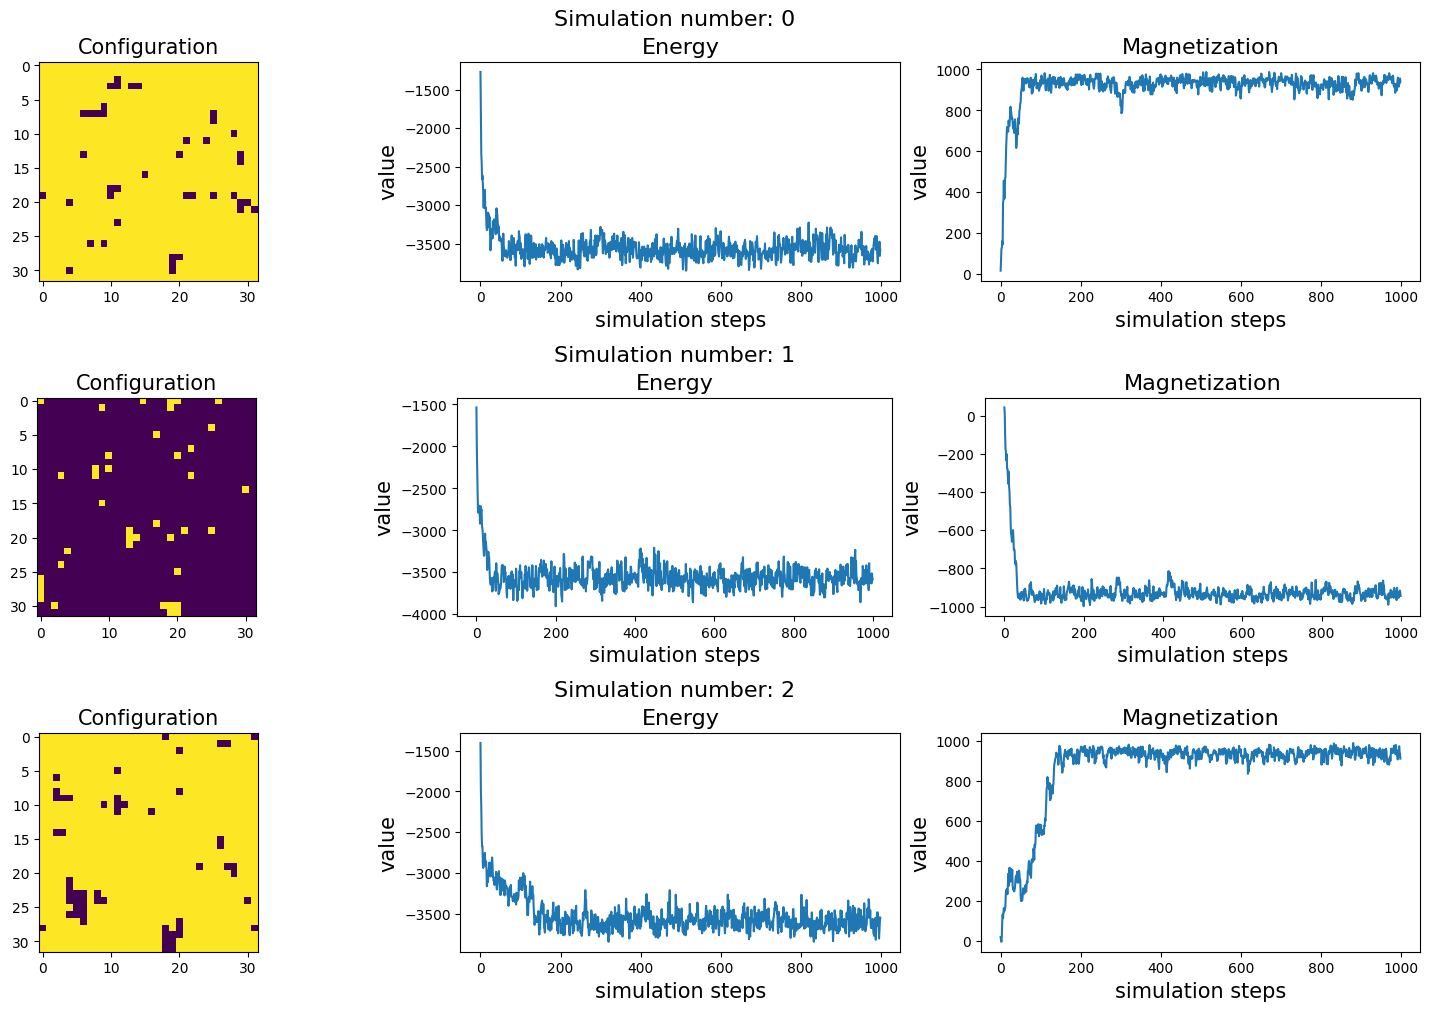

In [2]:
time_series("Demo/Low")

### High temperature
Simulation starts not too far from the equilibrium and oscilates vividly

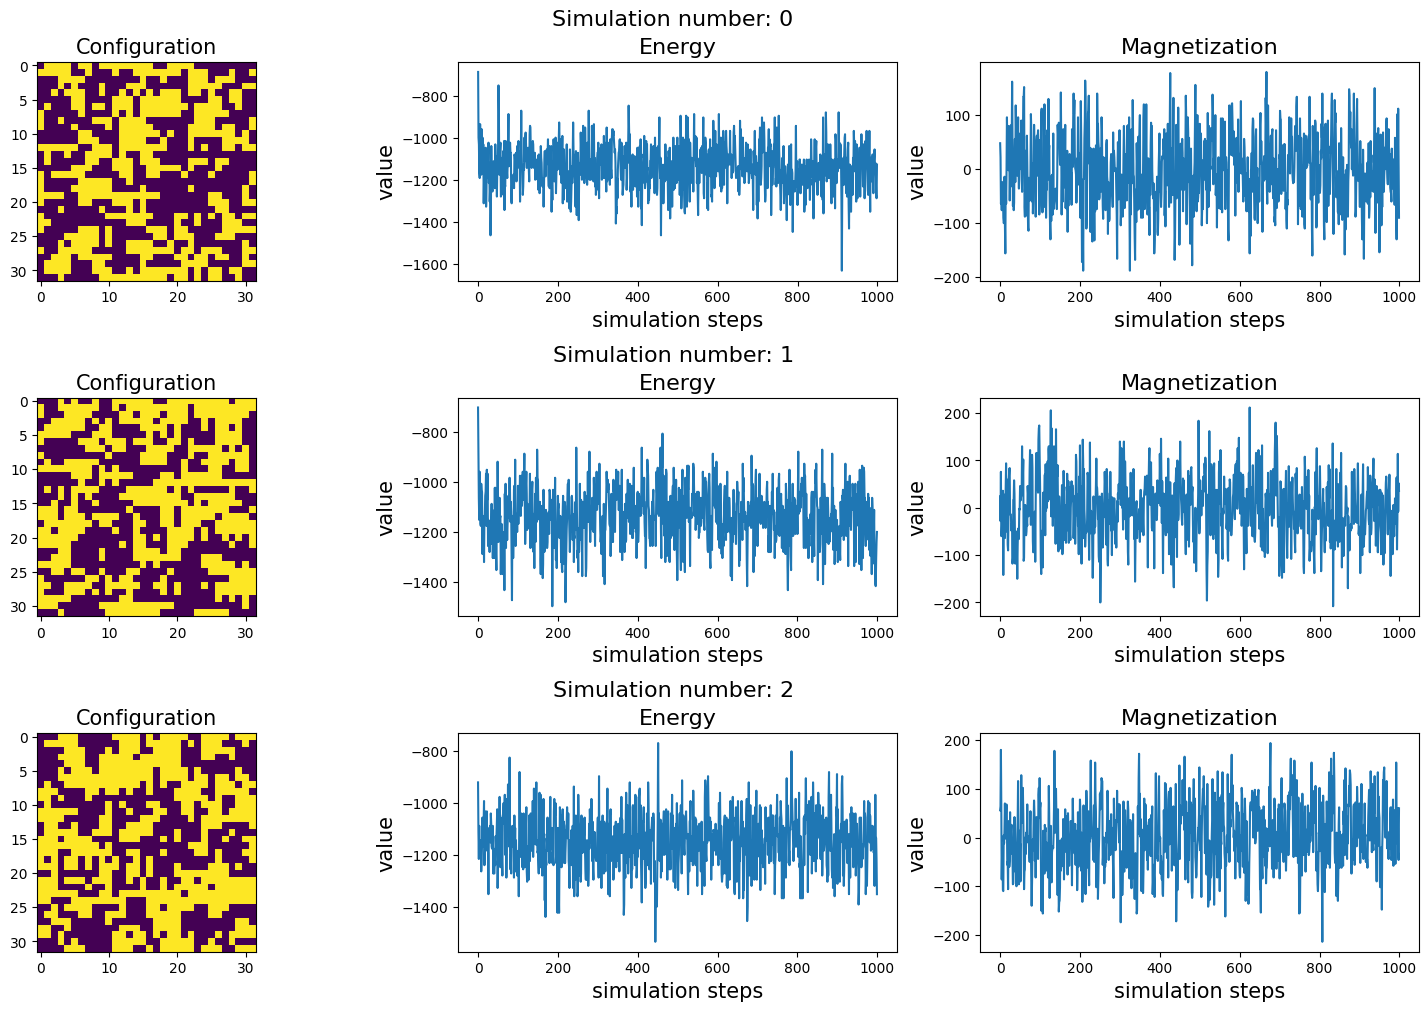

In [3]:
time_series("Demo/High")

### Around critical temperature
For 2d lattice with periodic boundary conditions $T_{crit} \approx 2.27$

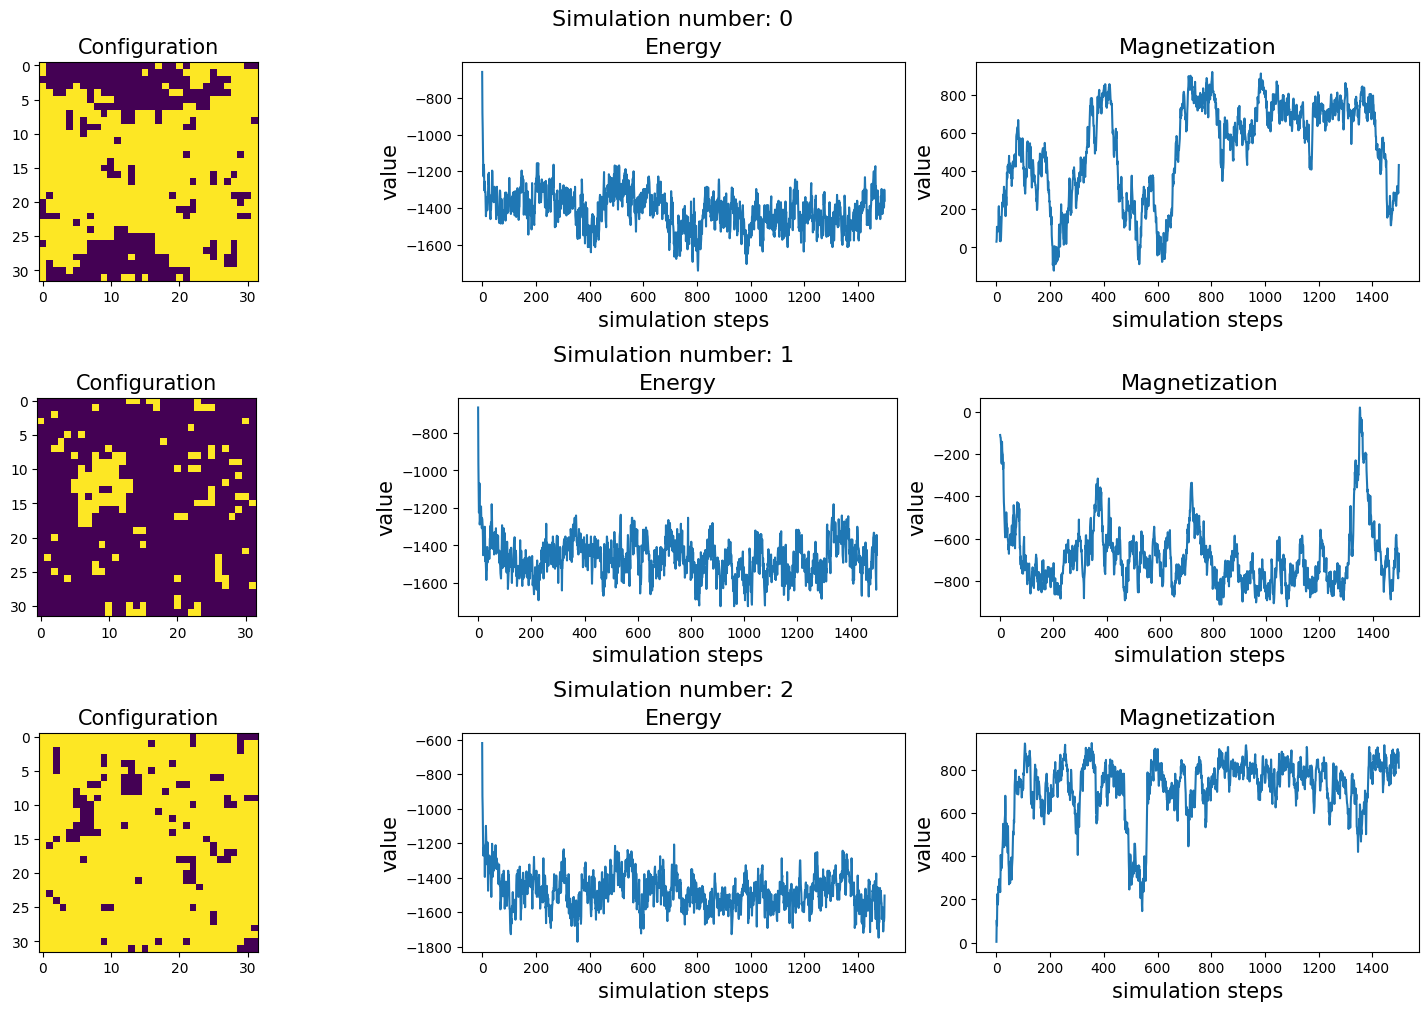

In [4]:
time_series("Demo/Crit")

### Positive Magnetic Field

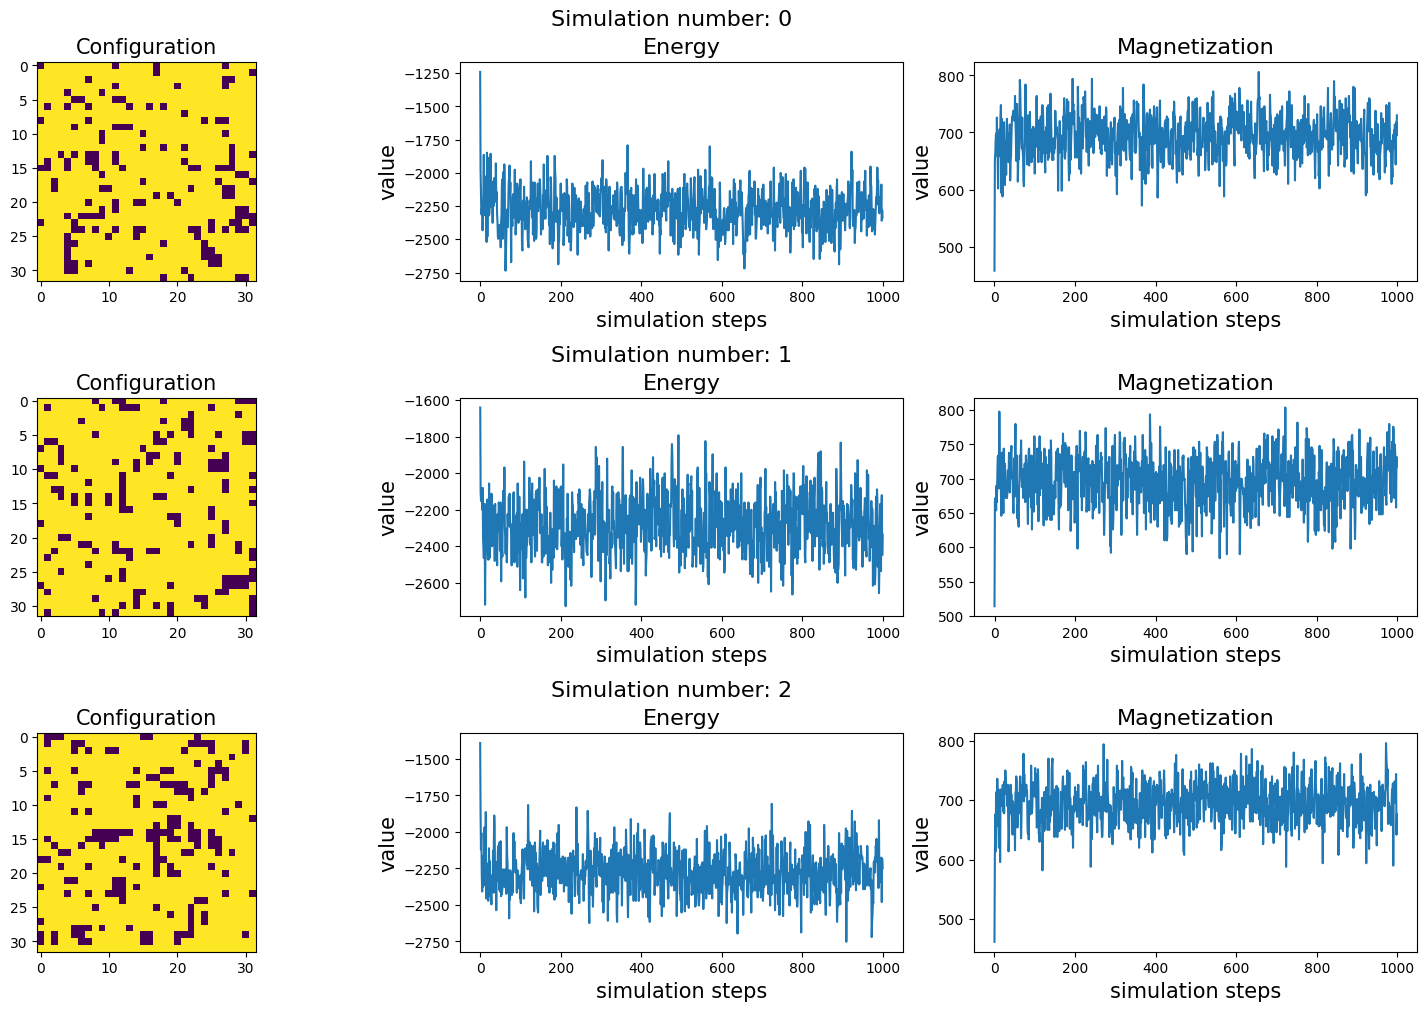

In [5]:
time_series("Demo/Pos")

### Negative Magnetic Field

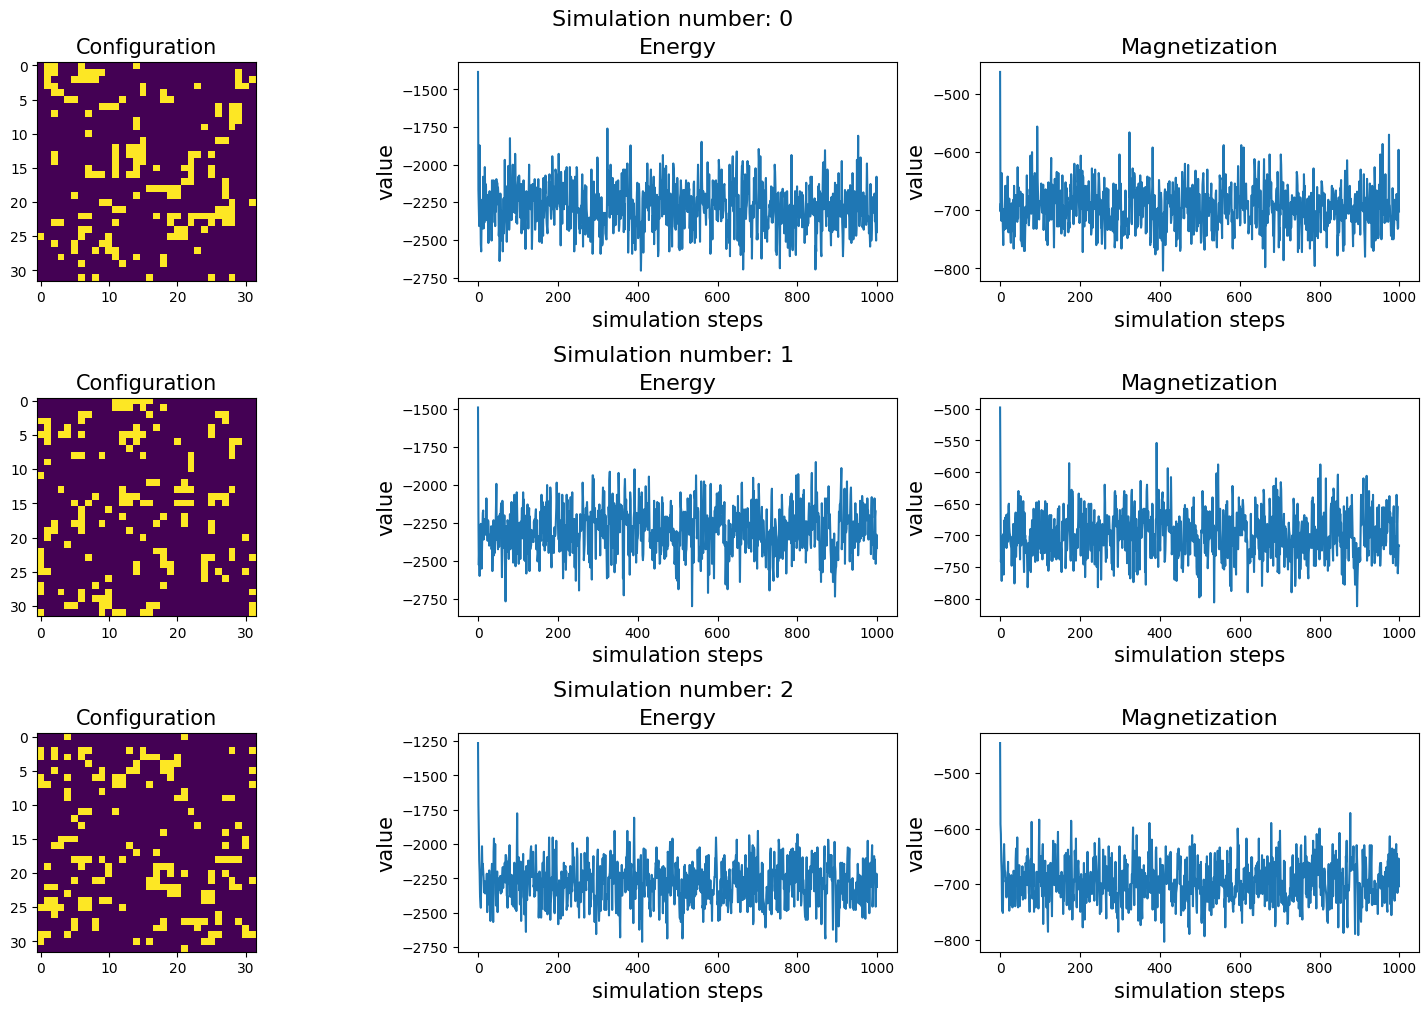

In [6]:
time_series("Demo/Neg")

## Wolff Algorithm

In each simulation of the Wolff algorithm, the following steps are performed:

1. **Cluster Construction**:
   - Start with an initial spin at a random location on the lattice.
   - Create a cluster of connected spins by adding (with some probability of success) neighboring spins that have the same orientation as the initial spin.<br><br>

2. **Cluster Flip**:
   - Once a cluster is constructed, all spins within the cluster are simultaneously flipped.<br><br>

3. **Update Magnetization and Energy**:
   - Calculate the new magnetization of the lattice and update the energy of the system.<br><br>

The Wolff algorithm is a cluster-based Monte Carlo method for simulating spin systems and is an alternative to the traditional Metropolis algorithm.<br>
It tends to be more efficient in simulating systems near critical points, where large clusters of spins tend to flip simultaneously, reducing the correlation time and improving the convergence of the simulation.



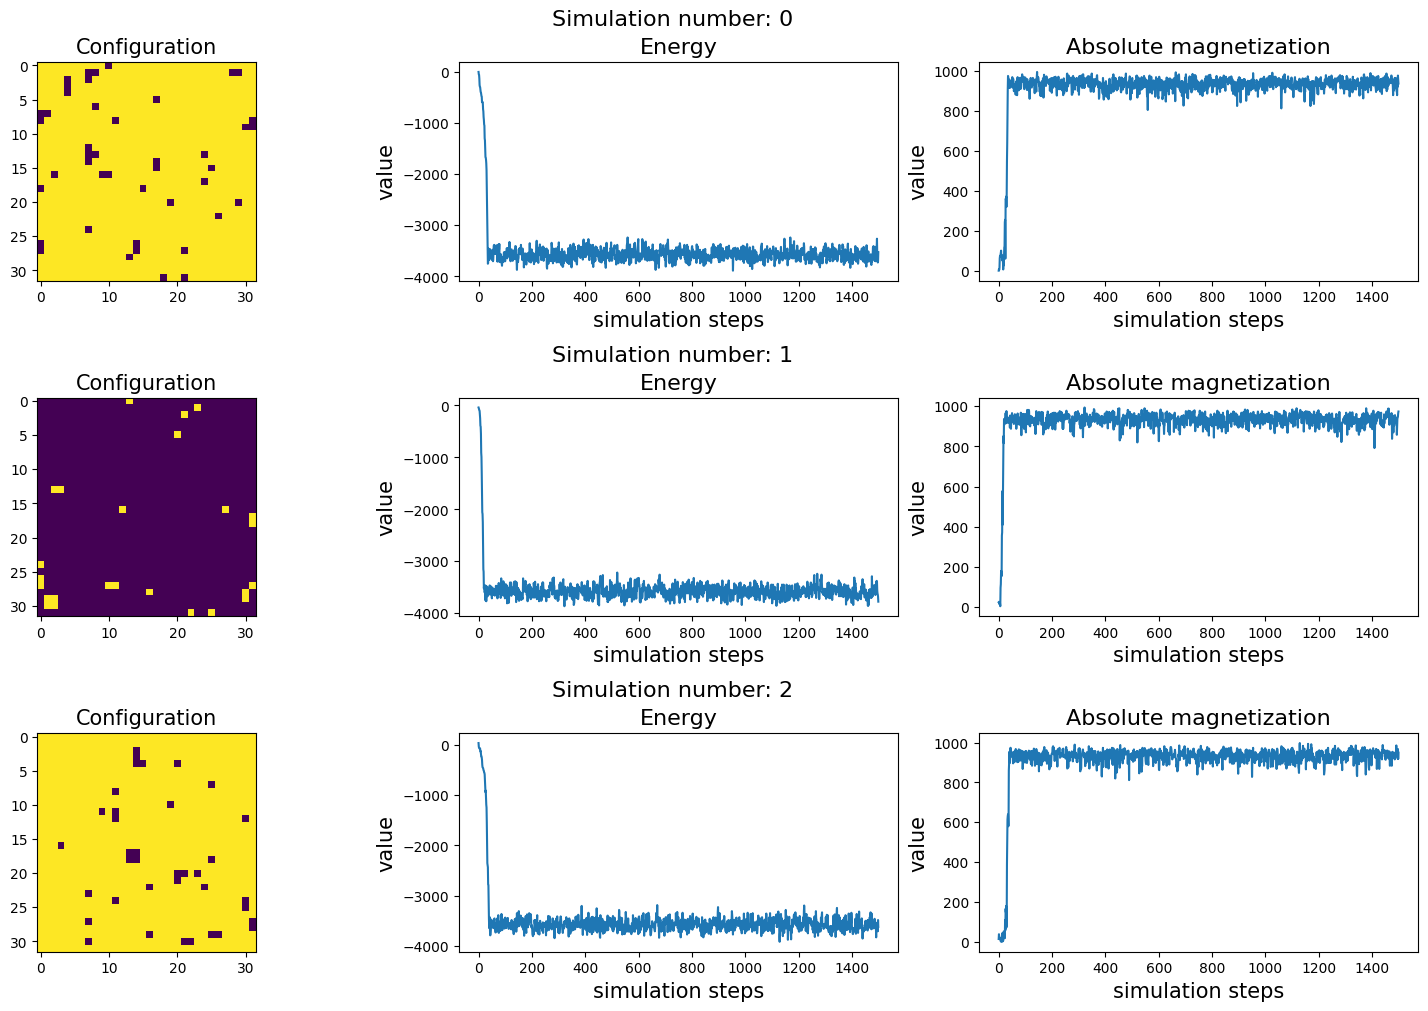

In [7]:
time_series("Demo/WolffLow/")

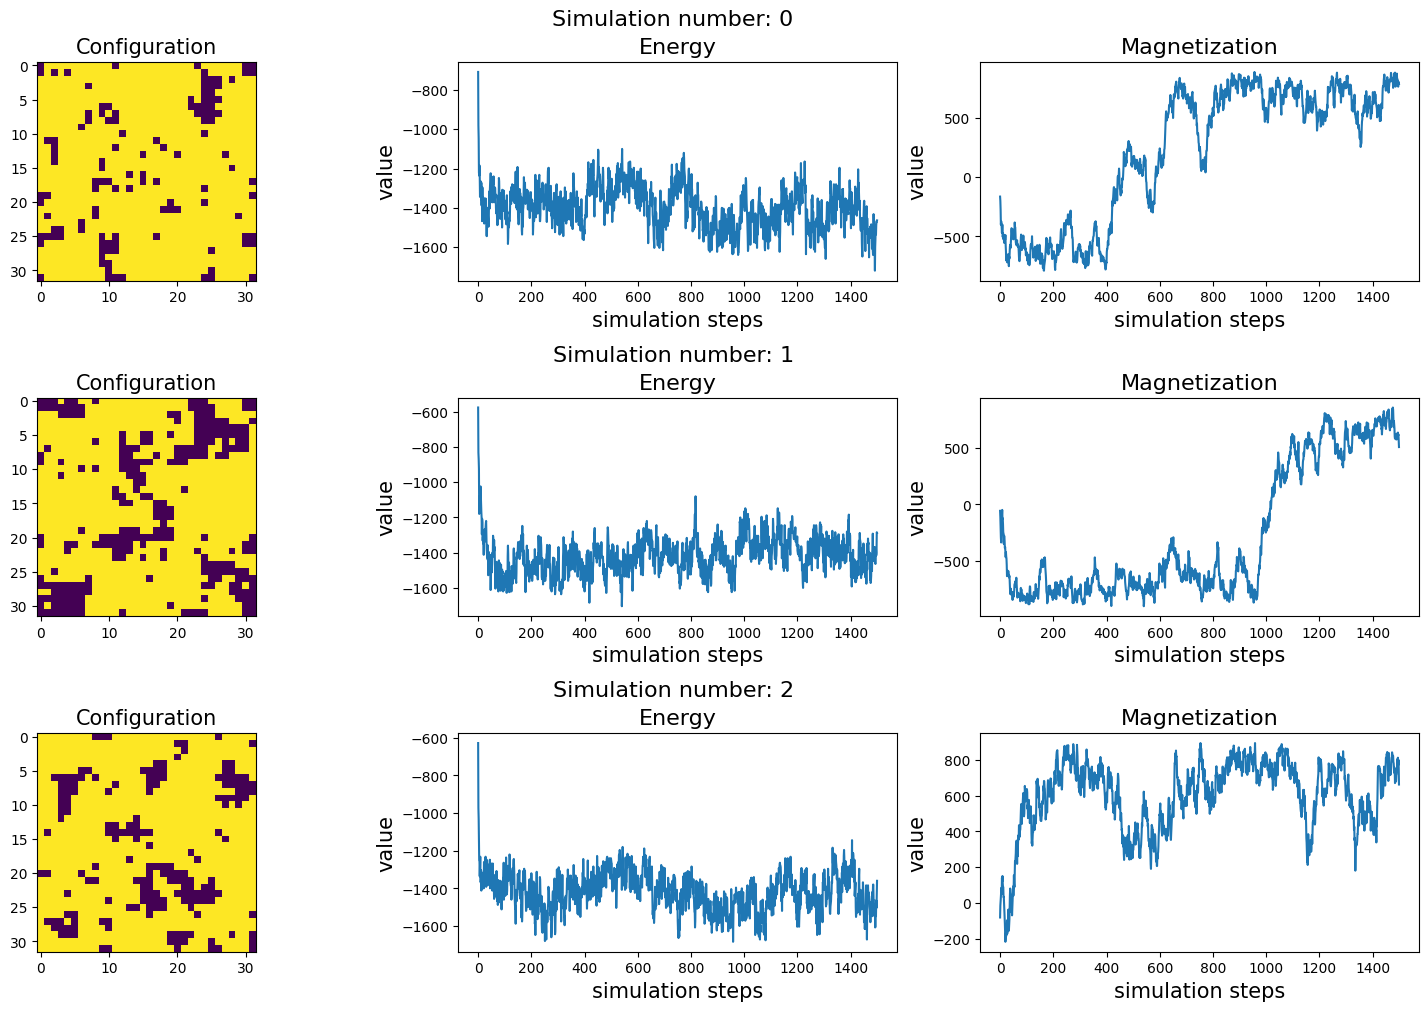

In [8]:
time_series("Demo/WolffCrit/")

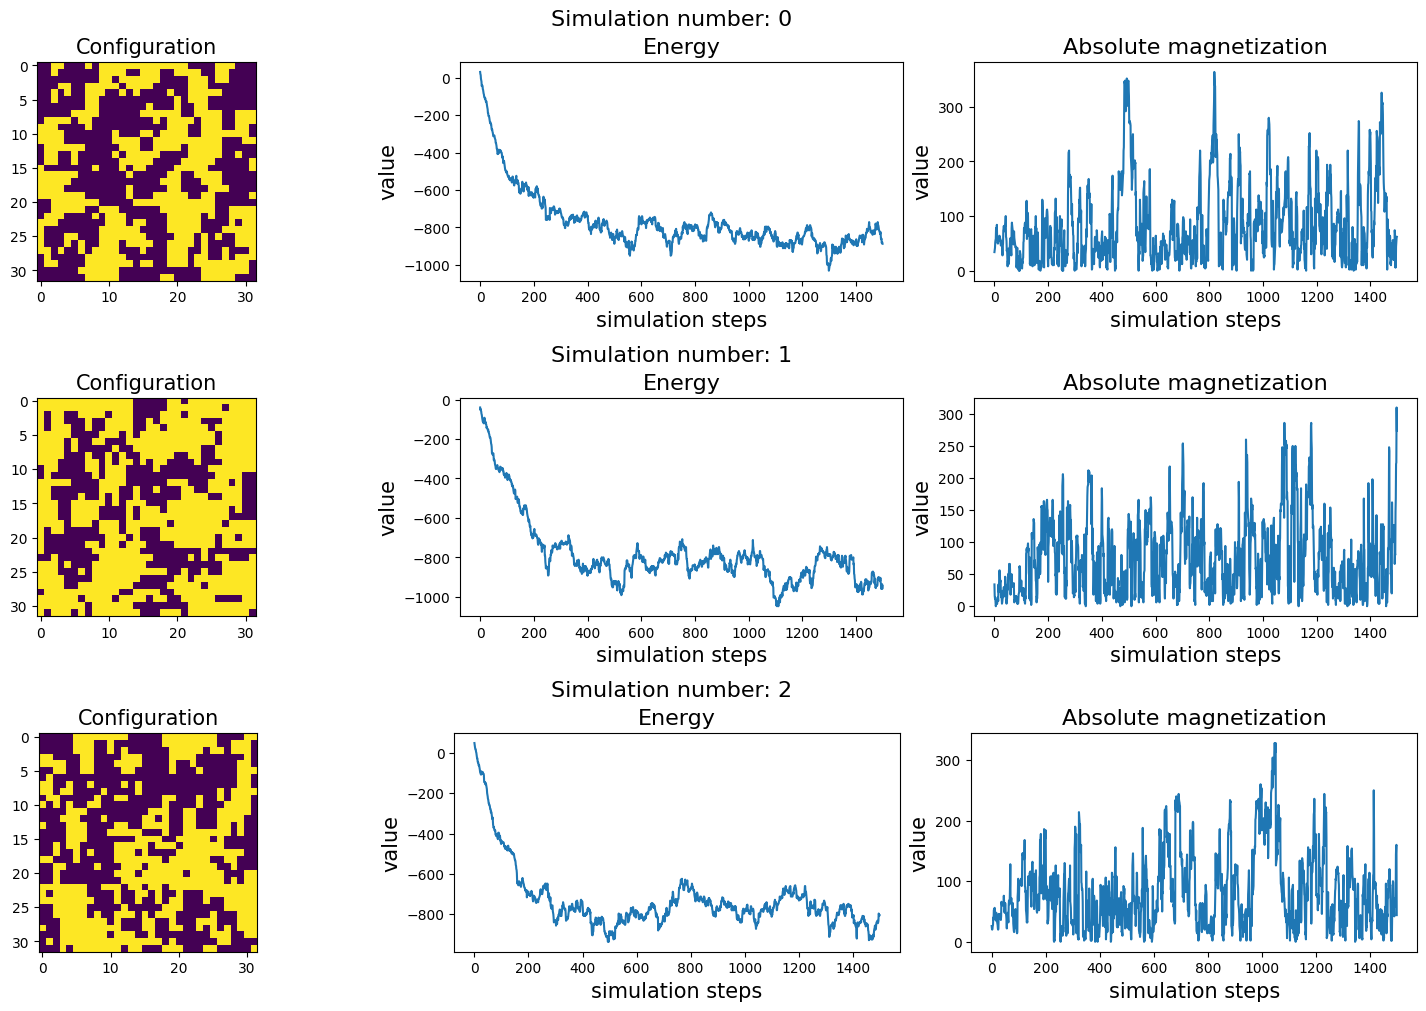

In [10]:
time_series("Demo/WolffHigh")
plt.savefig("../Plots/plot.svg")

## Compare Two algorithms

When dealing with thermalized states the energy distribution should be centered around some equilibrium energy.

Here we will compare metropolis algorithm with wolff for the same simulation parameters (temperature, magnetization, steps performed).



In [10]:
df_wolff = get_distribution_data('./Python/Data/TestWolff')
df_metro = get_distribution_data('./Python/Data/TestMetro')
df = pd.concat([df_wolff, df_metro])

File parameters:
{'Steps': '500', 'Simulatiton Number': '10000', 'Temperature': '2.0', 'Magnetic Field': '0.0', 'Mattize Size': '32', 'Wolff': 'True'}
File parameters:
{'Steps': '500', 'Simulatiton Number': '10000', 'Temperature': '2.0', 'Magnetic Field': '0.0', 'Mattize Size': '32', 'Wolff': 'False'}


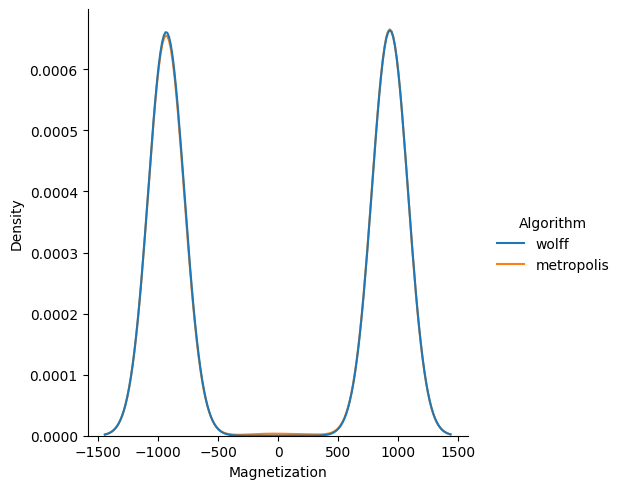

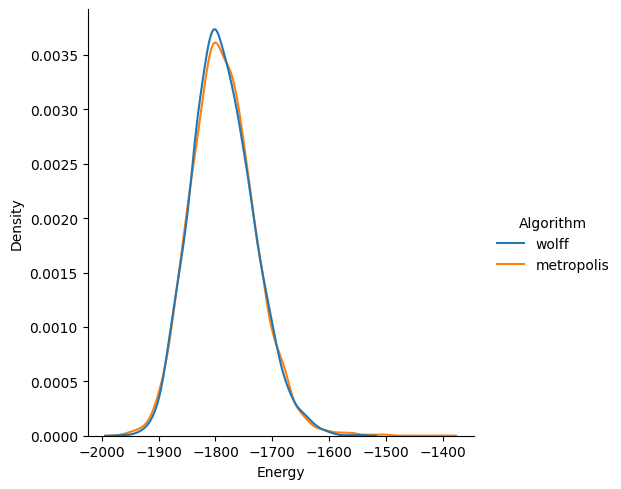

In [11]:
sns.displot(df, x = 'Magnetization', kind='kde', hue="Algorithm")
sns.displot(df, x = 'Energy', kind='kde', hue="Algorithm")

In this case enough steps of both algorithms has been made to thermalize the system. When generating dataset wolff algorithm was used.

# Generated Dataset

For each temperature between 2 and 3 degrees at iterval 0.1 50000 samples were generated.

To better investigate the temepartures close to critical one additional simulations were performed for t between 2.2 and 2.3 with interval of 0.02

In [3]:
from macro import validation_stats
from scipy.special import ellipe, ellipk

def analytic_c(t, J = 1):
    betaJ2 = 2 * J / t
    kappa = 2 * np.tanh(betaJ2) / np.cosh(betaJ2)
    kappa_prime = 2 * np.tanh(betaJ2) ** 2 - 1
    factor = 2 / np.pi * ( 1 / t *  1 / np.tanh(betaJ2)) ** 2
    value_kappa = 2 * ellipk(kappa ** 2) - 2 * ellipe(kappa ** 2) - (1 - kappa_prime) * (np.pi / 2 + kappa_prime * ellipk(kappa ** 2))
    return factor * value_kappa

def plot_hc(results):
    t_range = np.arange(2, 3, 0.01)
    plt.ylabel(r"specific heat $c$")
    plt.xlabel(r"temperature $t$")
    plt.plot(t_range, analytic_c(t_range), label = 'analytic solution', c = 'brown')
    plt.scatter(results[:, 0], results[:, 1] / L ** 2, label='simulations', c = 'green')
    plt.legend()

def plot_mc(results):
    plt.ylabel(r"magnetic susceptibility $c$")
    plt.xlabel(r"temperature $t$")
    plt.scatter(results[:, 0], results[:, 2], label = 'numerical simulations', c= 'blue')
    plt.legend()

L = 32
results = []
for t in np.arange(2, 3, 0.1):
    heat_capacity, magnetic_susceptibility = validation_stats(f"Python/Data/Data{t:.1f}", t)
    results.append((t, heat_capacity, magnetic_susceptibility))
for t in np.arange(2.22, 2.3, 0.02):
    heat_capacity, magnetic_susceptibility = validation_stats(f"Python/Data/Data{t:.2f}", t)
    results.append((t, heat_capacity, magnetic_susceptibility))
for t in np.arange(2.32, 2.4, 0.02):
    heat_capacity, magnetic_susceptibility = validation_stats(f"Python/Data/Data{t:.2f}", t)
    results.append((t, heat_capacity, magnetic_susceptibility))
results = np.array(results)

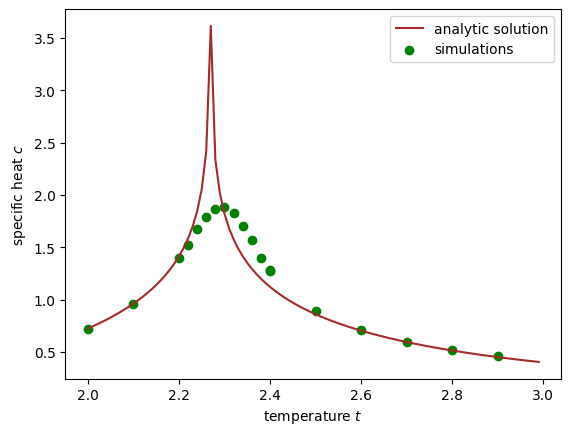

In [4]:
plot_hc(results)

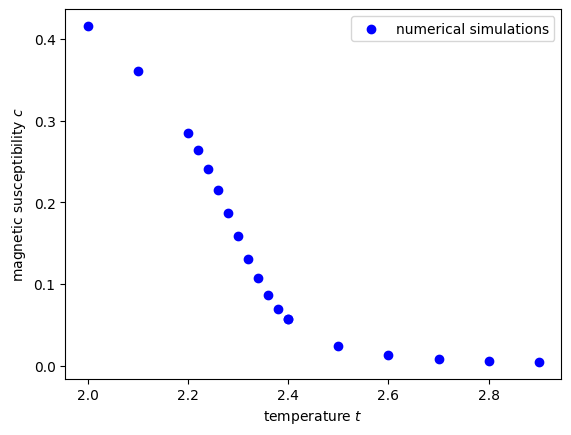

In [5]:
plot_mc(results)